In [37]:
# Cell 1 - Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# 🏠 House Price Prediction Model Comparison 🏠

This notebook compares different machine learning models for predicting house prices. We'll evaluate linear models, tree-based models, and ensembles to determine which approach provides the most accurate predictions.

## 📊 Data Preparation and Feature Engineering

First, we'll load the dataset and create enhanced features to improve our prediction power.

In [38]:
# Cell 2 - Load and preprocess data
# Load the dataset
df = pd.read_csv('menzli_modeling.csv')
df = df.drop('property_type', axis=1)

print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")

# Check for and fix any infinite or extremely large values
for col in df.columns:
    if df[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
        # Replace inf values with NaN
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
        # Fill NaN with column median
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())
            print(f"Fixed infinite or missing values in {col}")

# Display the first few rows
df.head()

Dataset loaded with 8774 rows and 33 columns


,price,bedrooms,bathrooms,total_rooms,living_area,land_area,has_climatisation,has_parabole_tv,has_pool,has_handicapped_access,...,has_kitchen_equipped,is_house,has_many_bedrooms,many_bathrooms,many_total_rooms,area_ratio,neighborhood_encoded,city_encoded,amenity_count,top_amenities_score
0,360000.0,3,1,4.0,110.0,110.0,0,0,0,0,...,0,0.0,0,0,0,1.0,609676.649713,421223.128405,0,0
1,320000.0,1,1,4.0,53.0,53.0,0,0,0,0,...,0,0.0,0,0,0,1.0,609676.649713,421223.128405,0,0
2,422000.0,2,2,3.0,125.0,125.0,1,1,0,0,...,1,0.0,0,0,0,1.0,479613.300971,427863.836948,11,0
3,245000.0,1,1,2.0,74.0,74.0,1,1,0,1,...,1,0.0,0,0,0,1.0,368515.753815,458256.960092,11,1
4,520000.0,3,2,4.0,152.0,152.0,1,1,0,0,...,1,0.0,0,0,0,1.0,449284.364346,421223.128405,12,0


## 🛠️ Feature Engineering

Feature engineering is crucial for improving model performance. We'll create:
- Log transformations for skewed numeric features
- Interaction terms between key features
- Squared terms to capture non-linear relationships

In [39]:
# Cell 3 - Feature Engineering
# Create log transformations
df['log_price'] = np.log1p(df['price'])
df['log_living_area'] = np.log1p(df['living_area'])
df['log_land_area'] = np.log1p(df['land_area'])

# Create interaction features
df['bed_bath'] = df['bedrooms'] * df['bathrooms']
df['bed_living'] = df['bedrooms'] * df['living_area']
df['total_rooms_squared'] = df['total_rooms'] ** 2
df['price_per_sqm'] = df['price'] / np.maximum(df['living_area'], 1)  # For analysis only

print("Feature engineering complete. New dataframe shape:", df.shape)

# Display summary statistics of the new features
df[['log_price', 'log_living_area', 'log_land_area', 'bed_bath', 'bed_living', 'total_rooms_squared']].describe()

Feature engineering complete. New dataframe shape: (8774, 40)


,log_price,log_living_area,log_land_area,bed_bath,bed_living,total_rooms_squared
count,8774.000000,8774.000000,8774.000000,8774.000000,8774.000000,8774.000000
mean,12.667925,5.047304,5.211972,6.390244,970.992392,29.015842
std,0.712145,0.671898,0.911173,7.215352,11677.837464,27.631135
min,10.714440,0.693147,0.693147,1.000000,1.000000,1.000000
25%,12.154785,4.615121,4.663439,2.000000,212.000000,9.000000
50%,12.611541,4.948760,5.056246,3.000000,420.000000,16.000000
75%,13.199326,5.476464,5.771441,8.000000,900.000000,36.000000
max,14.346139,12.301387,12.948012,60.000000,880000.000000,100.000000


## 🔍 Data Exploration

Before building models, let's explore the relationships between key features and house prices.

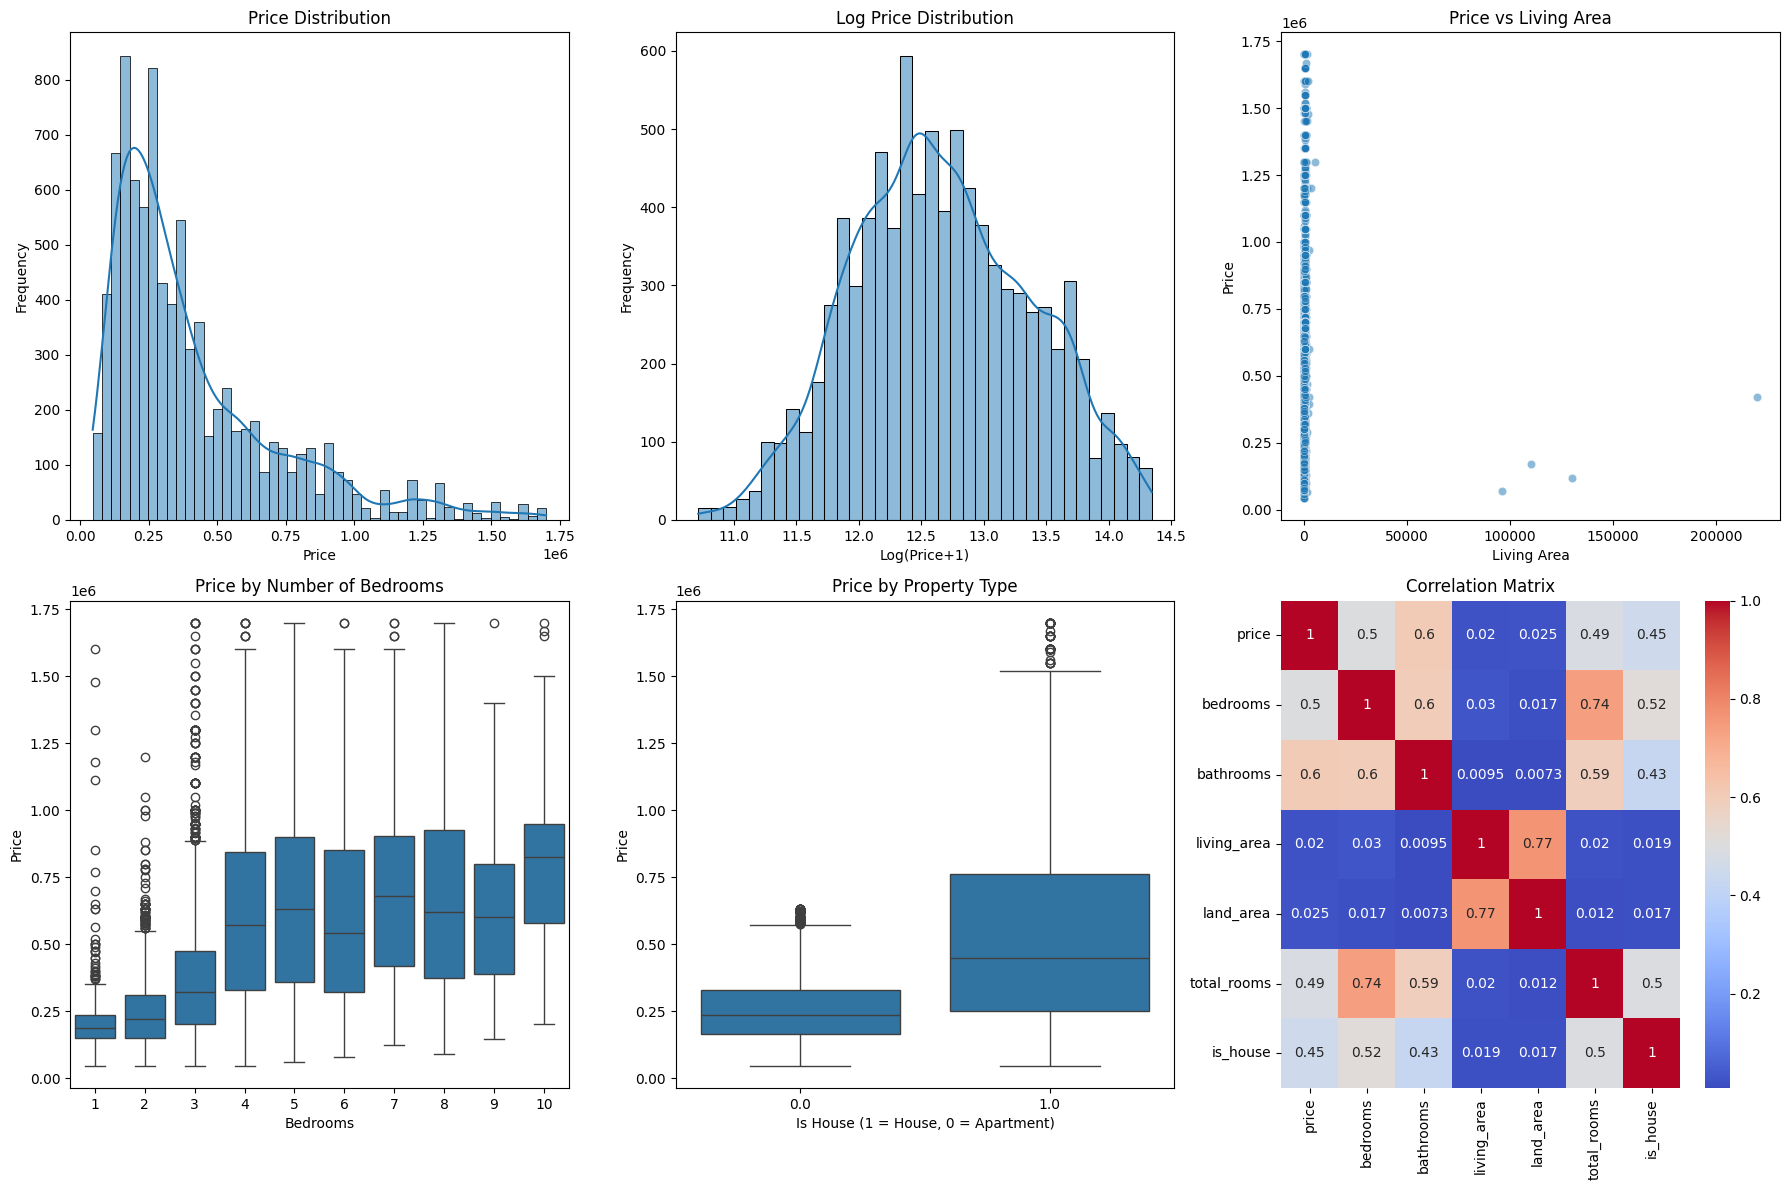

In [40]:
# Cell 4 - Data Exploration Visualizations
plt.figure(figsize=(18, 12))

# Plot 1: Price Distribution
plt.subplot(2, 3, 1)
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Plot 2: Log Price Distribution
plt.subplot(2, 3, 2)
sns.histplot(df['log_price'], kde=True)
plt.title('Log Price Distribution')
plt.xlabel('Log(Price+1)')
plt.ylabel('Frequency')

# Plot 3: Price vs Living Area
plt.subplot(2, 3, 3)
sns.scatterplot(x='living_area', y='price', data=df, alpha=0.5)
plt.title('Price vs Living Area')
plt.xlabel('Living Area')
plt.ylabel('Price')

# Plot 4: Price vs Bedrooms
plt.subplot(2, 3, 4)
sns.boxplot(x='bedrooms', y='price', data=df)
plt.title('Price by Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Price')

# Plot 5: Price by Property Type (is_house)
plt.subplot(2, 3, 5)
sns.boxplot(x='is_house', y='price', data=df)
plt.title('Price by Property Type')
plt.xlabel('Is House (1 = House, 0 = Apartment)')
plt.ylabel('Price')

# Plot 6: Correlation Matrix of Key Features
plt.subplot(2, 3, 6)
key_features = ['price', 'bedrooms', 'bathrooms', 'living_area', 'land_area', 'total_rooms', 'is_house']
sns.heatmap(df[key_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

plt.tight_layout()
plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

## 🔢 Data Preparation for Modeling

Now we'll prepare our data for modeling by:
1. Defining our features (X) and target variables (y)
2. Splitting the data into training and testing sets
3. Scaling the features for models that require normalized inputs

In [41]:
# Cell 5 - Data Preparation
# Define two target variables: original price and log-transformed price
y_orig = df['price']
y_log = df['log_price']

# Define features - drop price related columns
X = df.drop(['price', 'log_price', 'price_per_sqm'], axis=1)
feature_names = X.columns.tolist()

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train_orig, y_test_orig = train_test_split(X, y_orig, test_size=0.2, random_state=42)
_, _, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Testing set: {X_test.shape[0]} samples, {X_test.shape[1]} features")

# Create a StandardScaler for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 7019 samples, 37 features
Testing set: 1755 samples, 37 features


## 📏 Model Evaluation Functions

We'll create functions to evaluate our models using multiple metrics and visualize the results.

In [42]:
# Cell 6 - Model Evaluation Functions
def evaluate_model(y_true, y_pred, model_name, is_log_scale=False):
    """Evaluate model performance with multiple metrics"""
    # If predictions were made on log scale, convert back to original scale
    if is_log_scale:
        y_pred = np.expm1(y_pred)
        if isinstance(y_true, pd.Series) and y_true.name == 'log_price':
            y_true = np.expm1(y_true)
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"MSE: {mse:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"MAE: {mae:,.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")
    
    return {
        'model_name': model_name,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2
    }

def plot_actual_vs_predicted(y_true, y_pred, model_name):
    """Plot actual vs predicted values with regression line"""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    
    # Add regression line
    z = np.polyfit(y_true, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_true, p(y_true), "b--", alpha=0.8, label='Regression Line')
    
    plt.title(f'Actual vs Predicted Values ({model_name})')
    plt.xlabel('Actual Price (DNT)')
    plt.ylabel('Predicted Price (DNT)')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'{model_name.replace(" ", "_").lower()}_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

## 📈 Linear Models

We'll start with linear models, which assume a linear relationship between features and target. These models are simpler and provide a good baseline for comparison.


--- Linear Regression ---

Linear Regression Results:
MSE: 36,375,725,235.29
RMSE: 190,724.21
MAE: 130,072.64
MAPE: 43.39%
R²: 0.6163


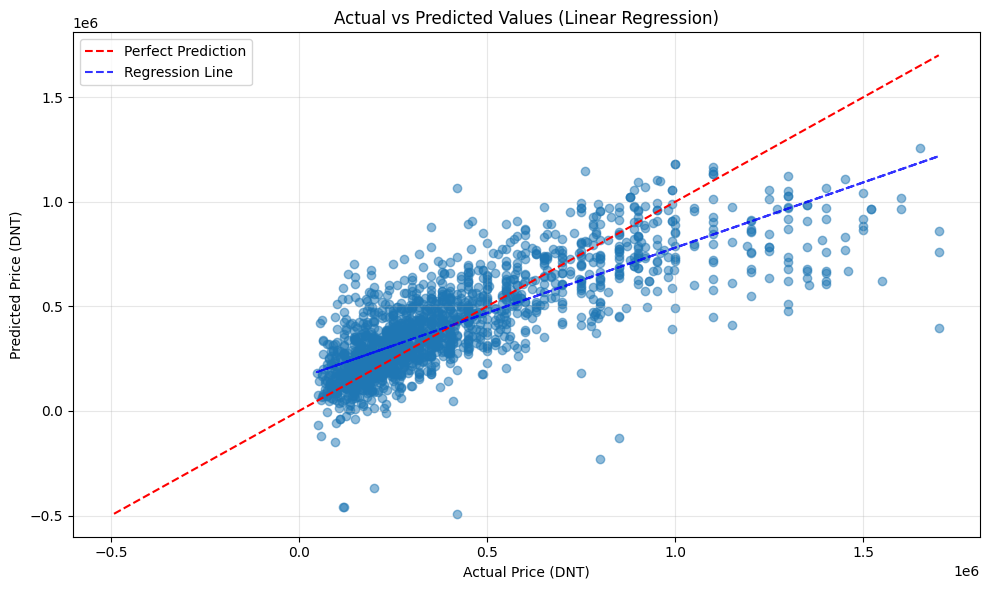


--- Ridge Regression ---
Ridge (alpha=0.1) - R²: 0.6163
Ridge (alpha=1.0) - R²: 0.6162
Ridge (alpha=10.0) - R²: 0.6157
Ridge (alpha=100.0) - R²: 0.6125

Best Ridge alpha: 0.1

Ridge (alpha=0.1) Results:
MSE: 36,376,267,957.39
RMSE: 190,725.64
MAE: 130,072.74
MAPE: 43.39%
R²: 0.6163


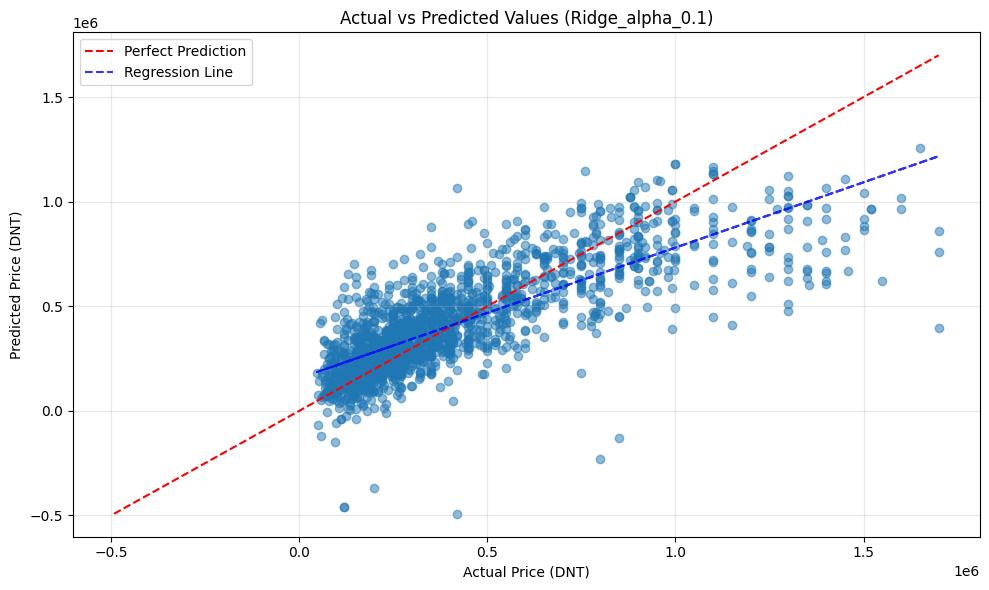


--- Lasso Regression ---
Lasso (alpha=0.001) - R²: 0.6163
Lasso (alpha=0.01) - R²: 0.6163
Lasso (alpha=0.1) - R²: 0.6163
Lasso (alpha=1.0) - R²: 0.6163

Best Lasso alpha: 0.001

Lasso (alpha=0.001) Results:
MSE: 36,375,726,219.56
RMSE: 190,724.22
MAE: 130,072.64
MAPE: 43.39%
R²: 0.6163


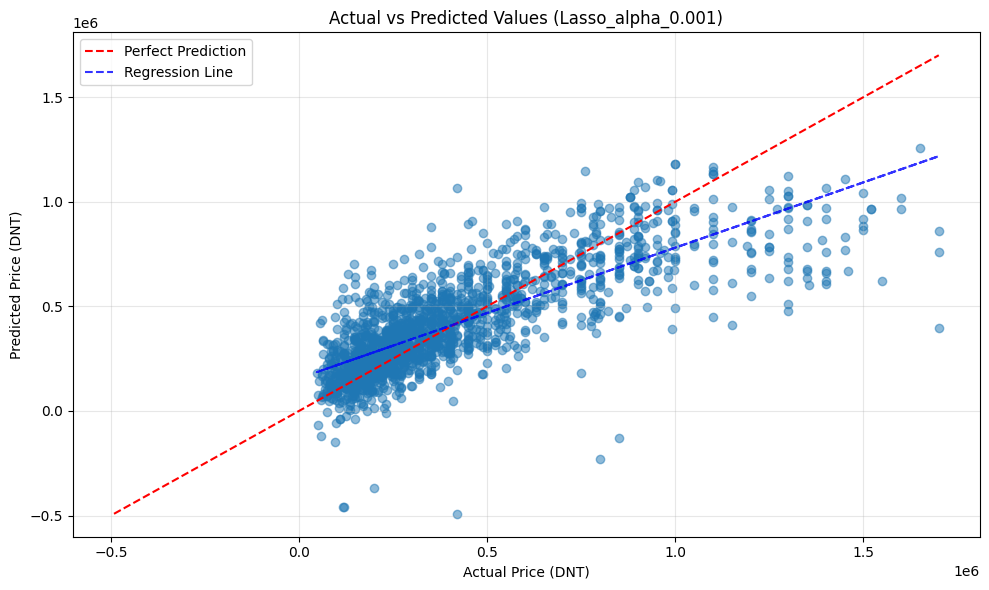


--- Linear Regression with Log-Transformed Target ---

Linear Regression (Log Target) Results:
MSE: 36,408,493,895.25
RMSE: 190,810.10
MAE: 122,785.23
MAPE: 34.93%
R²: 0.6159


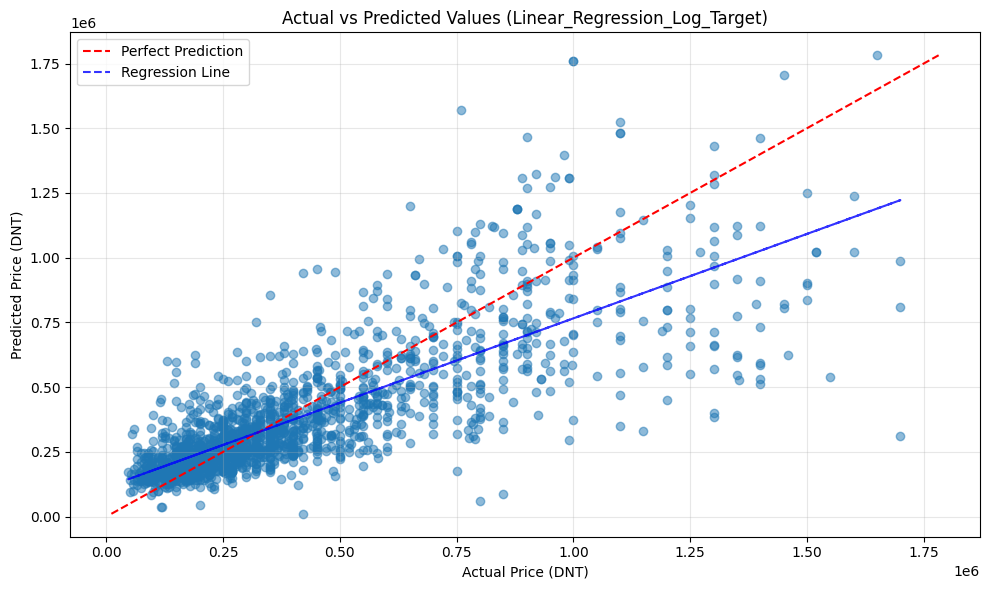

In [43]:
# Cell 7 - Linear Models
# Store all model results for comparison
all_results = []

# 1. Linear Regression
print("\n--- Linear Regression ---")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_orig)
lr_pred = lr.predict(X_test_scaled)
lr_results = evaluate_model(y_test_orig, lr_pred, "Linear Regression")
all_results.append(lr_results)
plot_actual_vs_predicted(y_test_orig, lr_pred, "Linear Regression")

# 2. Ridge Regression (L2 Regularization)
print("\n--- Ridge Regression ---")
ridge_alphas = [0.1, 1.0, 10.0, 100.0]
best_ridge_r2 = -np.inf
best_ridge_alpha = None
best_ridge_pred = None

for alpha in ridge_alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train_orig)
    ridge_pred = ridge.predict(X_test_scaled)
    r2 = r2_score(y_test_orig, ridge_pred)
    print(f"Ridge (alpha={alpha}) - R²: {r2:.4f}")
    
    if r2 > best_ridge_r2:
        best_ridge_r2 = r2
        best_ridge_alpha = alpha
        best_ridge_pred = ridge_pred

print(f"\nBest Ridge alpha: {best_ridge_alpha}")
ridge_results = evaluate_model(y_test_orig, best_ridge_pred, f"Ridge (alpha={best_ridge_alpha})")
all_results.append(ridge_results)
plot_actual_vs_predicted(y_test_orig, best_ridge_pred, f"Ridge_alpha_{best_ridge_alpha}")

# 3. Lasso Regression (L1 Regularization)
print("\n--- Lasso Regression ---")
lasso_alphas = [0.001, 0.01, 0.1, 1.0]
best_lasso_r2 = -np.inf
best_lasso_alpha = None
best_lasso_pred = None

for alpha in lasso_alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train_orig)
    lasso_pred = lasso.predict(X_test_scaled)
    r2 = r2_score(y_test_orig, lasso_pred)
    print(f"Lasso (alpha={alpha}) - R²: {r2:.4f}")
    
    if r2 > best_lasso_r2:
        best_lasso_r2 = r2
        best_lasso_alpha = alpha
        best_lasso_pred = lasso_pred

print(f"\nBest Lasso alpha: {best_lasso_alpha}")
lasso_results = evaluate_model(y_test_orig, best_lasso_pred, f"Lasso (alpha={best_lasso_alpha})")
all_results.append(lasso_results)
plot_actual_vs_predicted(y_test_orig, best_lasso_pred, f"Lasso_alpha_{best_lasso_alpha}")

# 4. Linear Regression with Log-Transformed Target
print("\n--- Linear Regression with Log-Transformed Target ---")
lr_log = LinearRegression()
lr_log.fit(X_train_scaled, y_train_log)
lr_log_pred = lr_log.predict(X_test_scaled)
lr_log_results = evaluate_model(y_test_orig, lr_log_pred, "Linear Regression (Log Target)", is_log_scale=True)
all_results.append(lr_log_results)
plot_actual_vs_predicted(y_test_orig, np.expm1(lr_log_pred), "Linear_Regression_Log_Target")

## 🌲 Tree-Based Models

Tree-based models can capture non-linear relationships and interactions between features without requiring explicit feature transformations. They tend to perform well on structured data like housing information.


--- Random Forest ---

Random Forest Results:
MSE: 26,008,861,544.78
RMSE: 161,272.63
MAE: 101,377.60
MAPE: 32.94%
R²: 0.7256


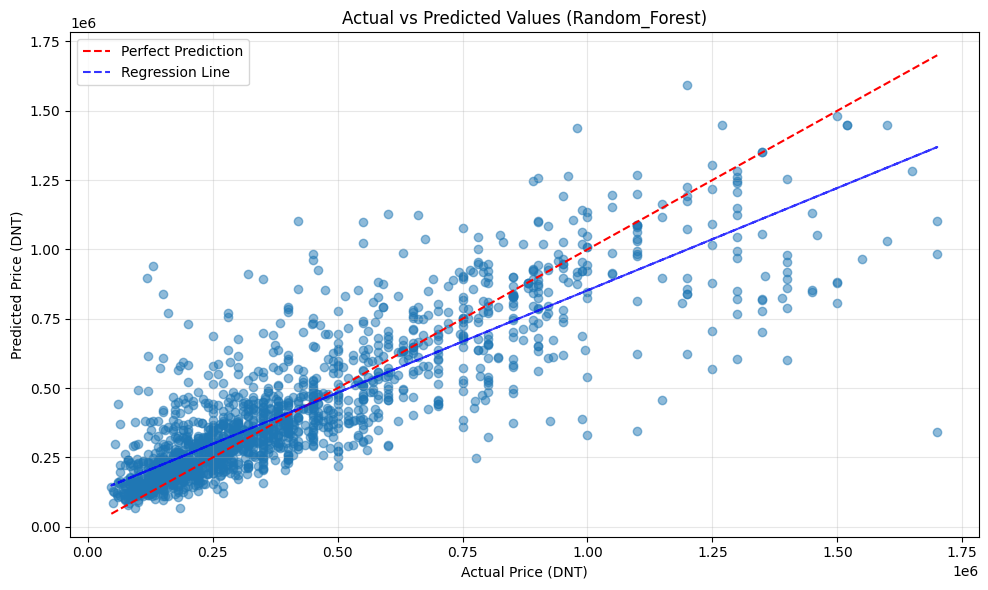


--- Random Forest with Log-Transformed Target ---

Random Forest (Log Target) Results:
MSE: 27,045,775,373.41
RMSE: 164,456.00
MAE: 100,320.90
MAPE: 29.34%
R²: 0.7147


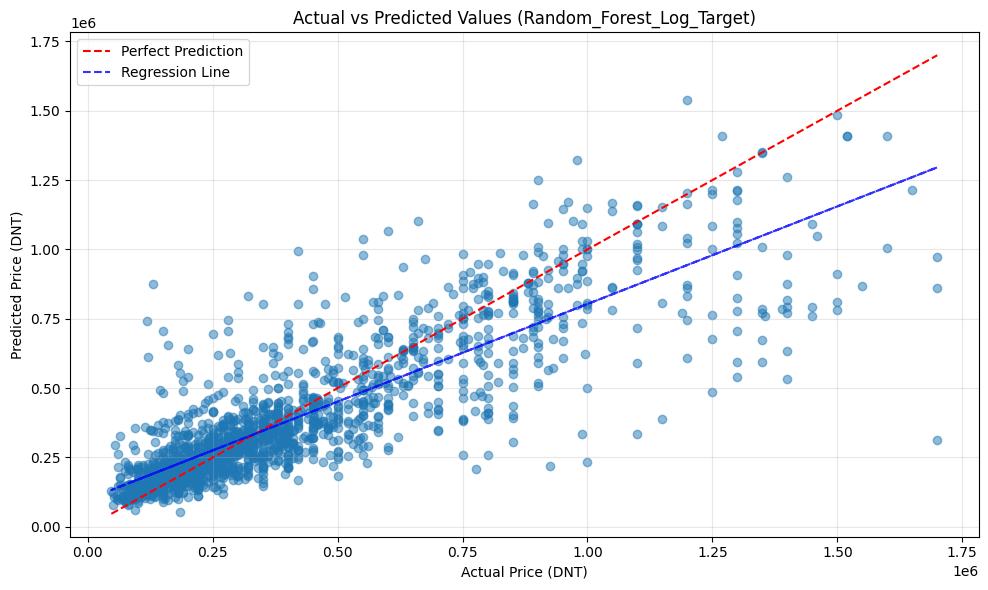


--- Gradient Boosting ---

Gradient Boosting Results:
MSE: 25,461,189,805.46
RMSE: 159,565.63
MAE: 102,970.43
MAPE: 32.26%
R²: 0.7314


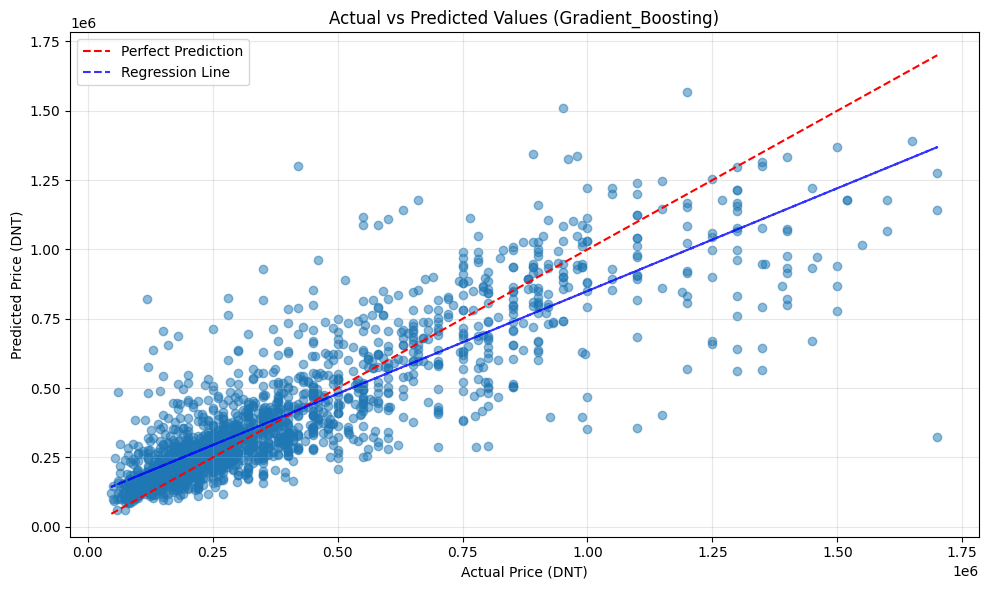


--- Gradient Boosting with Log-Transformed Target ---

Gradient Boosting (Log Target) Results:
MSE: 25,428,411,392.13
RMSE: 159,462.88
MAE: 99,016.25
MAPE: 28.19%
R²: 0.7318


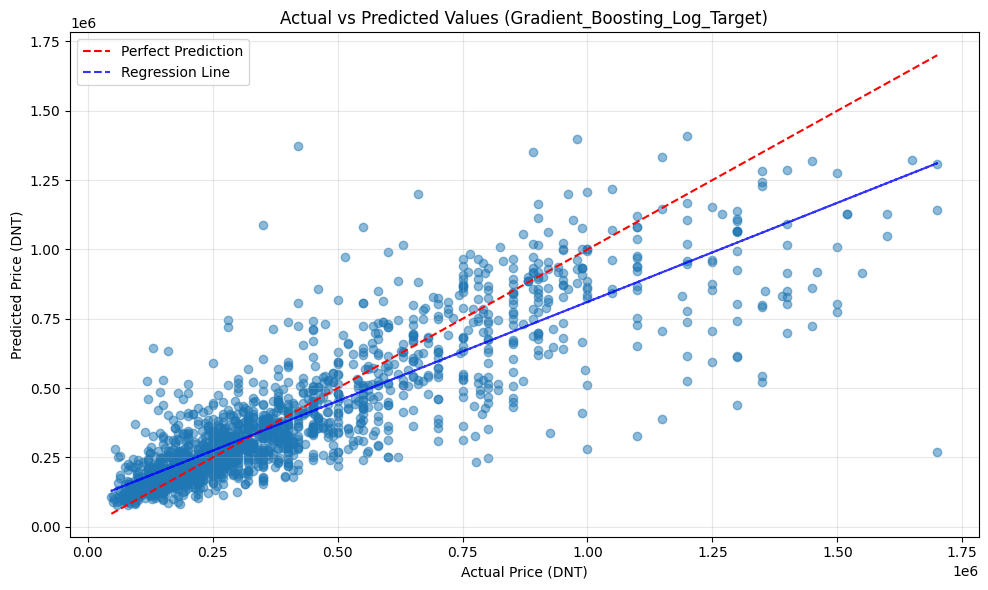


--- XGBoost ---

XGBoost Results:
MSE: 25,001,988,292.32
RMSE: 158,120.17
MAE: 103,239.29
MAPE: 32.98%
R²: 0.7363


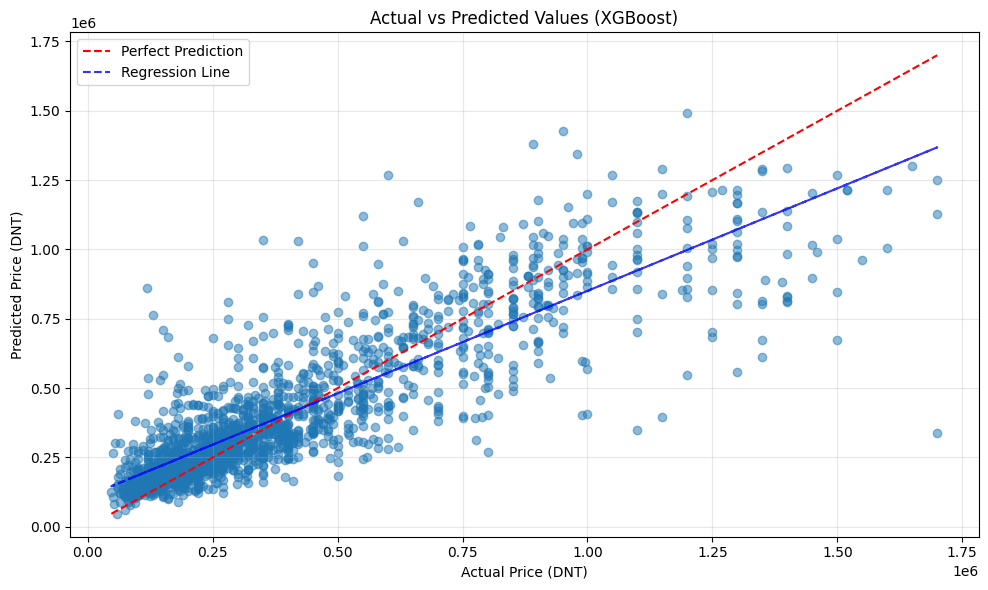


--- XGBoost with Log-Transformed Target ---

XGBoost (Log Target) Results:
MSE: 25,894,041,301.81
RMSE: 160,916.26
MAE: 101,091.08
MAPE: 28.72%
R²: 0.7268


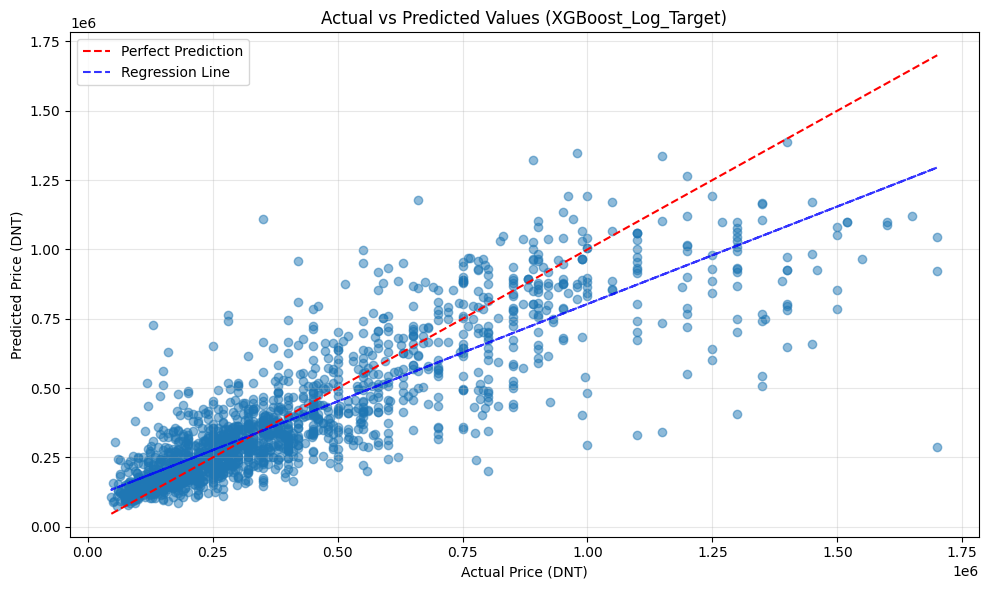


--- Optimized XGBoost ---

XGBoost (Optimized) Results:
MSE: 24,912,709,847.43
RMSE: 157,837.61
MAE: 98,235.24
MAPE: 28.02%
R²: 0.7372


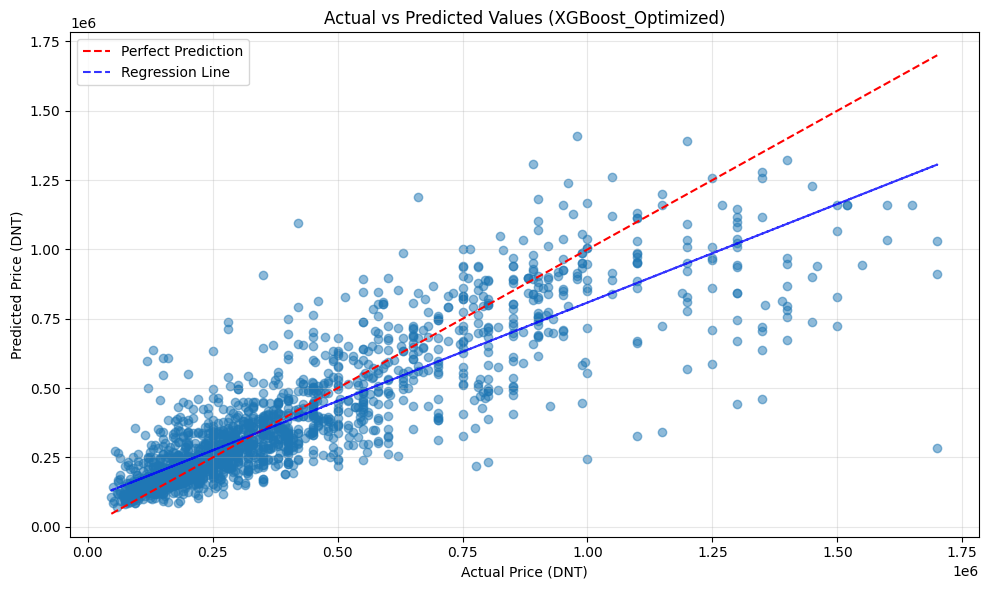

In [44]:
# Cell 8 - Tree-Based Models
# 1. Random Forest
print("\n--- Random Forest ---")
rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42)
rf.fit(X_train, y_train_orig)
rf_pred = rf.predict(X_test)
rf_results = evaluate_model(y_test_orig, rf_pred, "Random Forest")
all_results.append(rf_results)
plot_actual_vs_predicted(y_test_orig, rf_pred, "Random_Forest")

# 2. Random Forest with Log-Transformed Target
print("\n--- Random Forest with Log-Transformed Target ---")
rf_log = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42)
rf_log.fit(X_train, y_train_log)
rf_log_pred = rf_log.predict(X_test)
rf_log_results = evaluate_model(y_test_orig, rf_log_pred, "Random Forest (Log Target)", is_log_scale=True)
all_results.append(rf_log_results)
plot_actual_vs_predicted(y_test_orig, np.expm1(rf_log_pred), "Random_Forest_Log_Target")

# 3. Gradient Boosting
print("\n--- Gradient Boosting ---")
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gb.fit(X_train, y_train_orig)
gb_pred = gb.predict(X_test)
gb_results = evaluate_model(y_test_orig, gb_pred, "Gradient Boosting")
all_results.append(gb_results)
plot_actual_vs_predicted(y_test_orig, gb_pred, "Gradient_Boosting")

# 4. Gradient Boosting with Log-Transformed Target
print("\n--- Gradient Boosting with Log-Transformed Target ---")
gb_log = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gb_log.fit(X_train, y_train_log)
gb_log_pred = gb_log.predict(X_test)
gb_log_results = evaluate_model(y_test_orig, gb_log_pred, "Gradient Boosting (Log Target)", is_log_scale=True)
all_results.append(gb_log_results)
plot_actual_vs_predicted(y_test_orig, np.expm1(gb_log_pred), "Gradient_Boosting_Log_Target")

# 5. XGBoost
print("\n--- XGBoost ---")
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train_orig)
xgb_pred = xgb_model.predict(X_test)
xgb_results = evaluate_model(y_test_orig, xgb_pred, "XGBoost")
all_results.append(xgb_results)
plot_actual_vs_predicted(y_test_orig, xgb_pred, "XGBoost")

# 6. XGBoost with Log-Transformed Target
print("\n--- XGBoost with Log-Transformed Target ---")
xgb_log = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
xgb_log.fit(X_train, y_train_log)
xgb_log_pred = xgb_log.predict(X_test)
xgb_log_results = evaluate_model(y_test_orig, xgb_log_pred, "XGBoost (Log Target)", is_log_scale=True)
all_results.append(xgb_log_results)
plot_actual_vs_predicted(y_test_orig, np.expm1(xgb_log_pred), "XGBoost_Log_Target")

# 7. Optimized XGBoost
print("\n--- Optimized XGBoost ---")
xgb_optimized = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)
xgb_optimized.fit(X_train, y_train_log)
xgb_opt_pred = xgb_optimized.predict(X_test)
xgb_opt_results = evaluate_model(y_test_orig, xgb_opt_pred, "XGBoost (Optimized)", is_log_scale=True)
all_results.append(xgb_opt_results)
plot_actual_vs_predicted(y_test_orig, np.expm1(xgb_opt_pred), "XGBoost_Optimized")

## 🌟 Advanced Models and Ensembles

We'll now explore more sophisticated models including ensemble techniques that combine multiple models to achieve better performance than any individual model.


--- Extra Trees Regressor ---

Extra Trees Results:
MSE: 27,088,705,841.63
RMSE: 164,586.47
MAE: 99,107.86
MAPE: 29.29%
R²: 0.7142


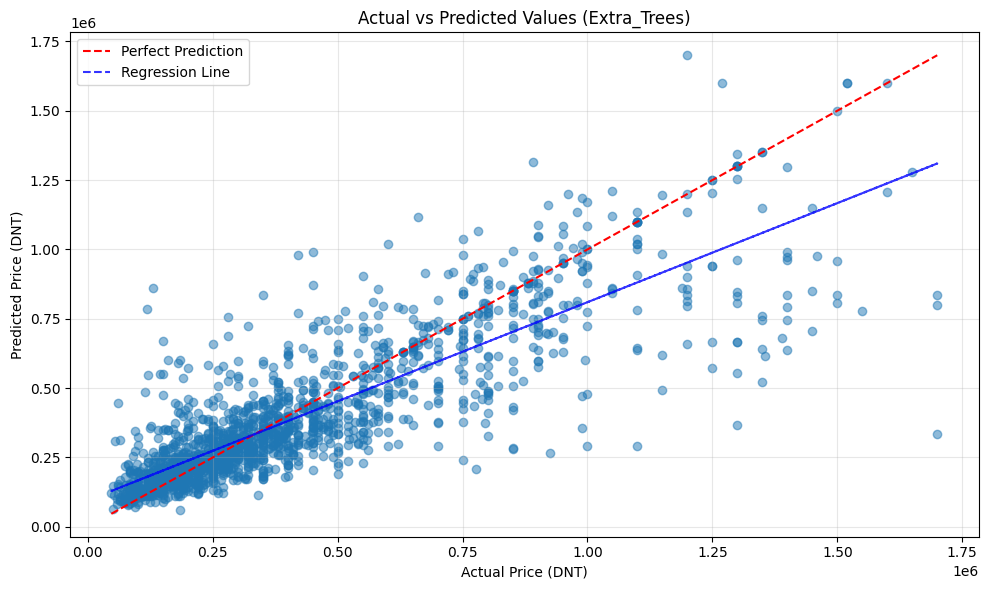


--- Stacking Regressor ---

Stacking Ensemble Results:
MSE: 25,545,128,844.79
RMSE: 159,828.44
MAE: 99,172.84
MAPE: 28.37%
R²: 0.7305


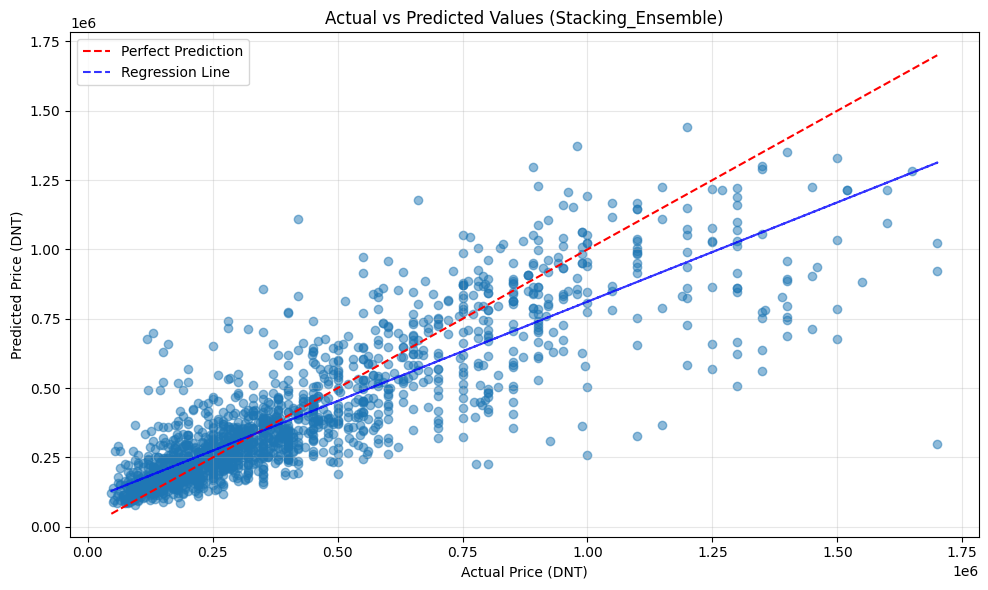


--- Voting Regressor ---

Voting Ensemble Results:
MSE: 25,946,205,684.01
RMSE: 161,078.26
MAE: 100,121.46
MAPE: 28.52%
R²: 0.7263


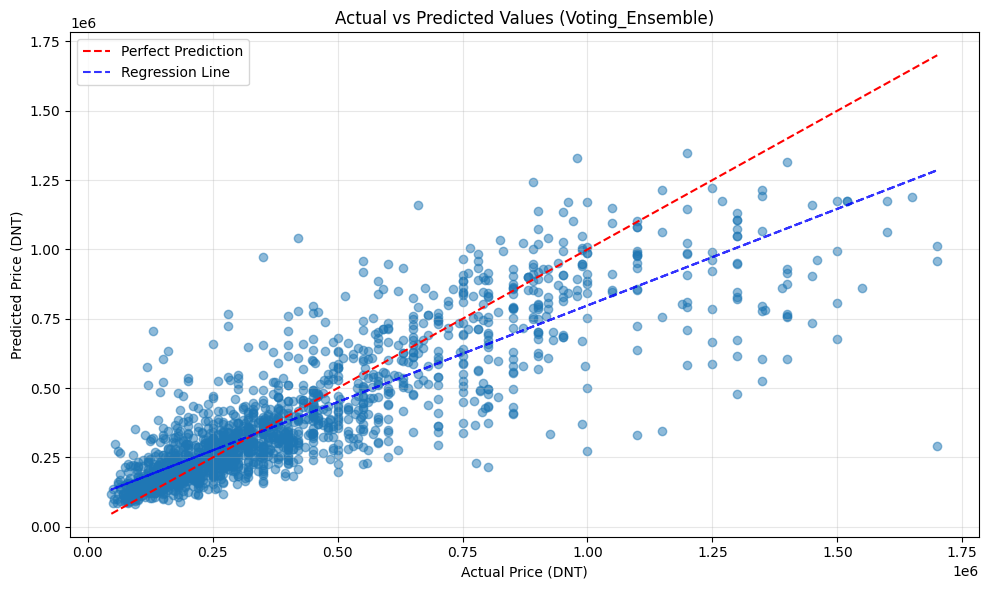

In [45]:
# Cell 9 - Advanced Models and Ensembles
from sklearn.ensemble import ExtraTreesRegressor, StackingRegressor, VotingRegressor
from sklearn.model_selection import KFold

# 1. Extra Trees Regressor
print("\n--- Extra Trees Regressor ---")
et = ExtraTreesRegressor(n_estimators=200, max_depth=None, random_state=42)
et.fit(X_train, y_train_log)
et_pred = et.predict(X_test)
et_results = evaluate_model(y_test_orig, et_pred, "Extra Trees", is_log_scale=True)
all_results.append(et_results)
plot_actual_vs_predicted(y_test_orig, np.expm1(et_pred), "Extra_Trees")

# 2. Stacking Regressor
print("\n--- Stacking Regressor ---")
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42))
]
meta_model = Ridge(alpha=10.0)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

stacking = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=cv,
    n_jobs=-1
)

stacking.fit(X_train, y_train_log)
stacking_pred = stacking.predict(X_test)
stacking_results = evaluate_model(y_test_orig, stacking_pred, "Stacking Ensemble", is_log_scale=True)
all_results.append(stacking_results)
plot_actual_vs_predicted(y_test_orig, np.expm1(stacking_pred), "Stacking_Ensemble")

# 3. Voting Regressor
print("\n--- Voting Regressor ---")
voting_models = [
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)),
    ('xgb', xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42))
]

voting = VotingRegressor(
    estimators=voting_models,
    weights=[1, 1, 2]  # Give more weight to XGBoost
)

voting.fit(X_train, y_train_log)
voting_pred = voting.predict(X_test)
voting_results = evaluate_model(y_test_orig, voting_pred, "Voting Ensemble", is_log_scale=True)
all_results.append(voting_results)
plot_actual_vs_predicted(y_test_orig, np.expm1(voting_pred), "Voting_Ensemble")

## 🧩 Feature Selection and Super Ensemble

Feature selection can improve model performance by removing noise, while ensemble methods combine different models to achieve better results than any individual model.


--- Feature-Selected XGBoost ---


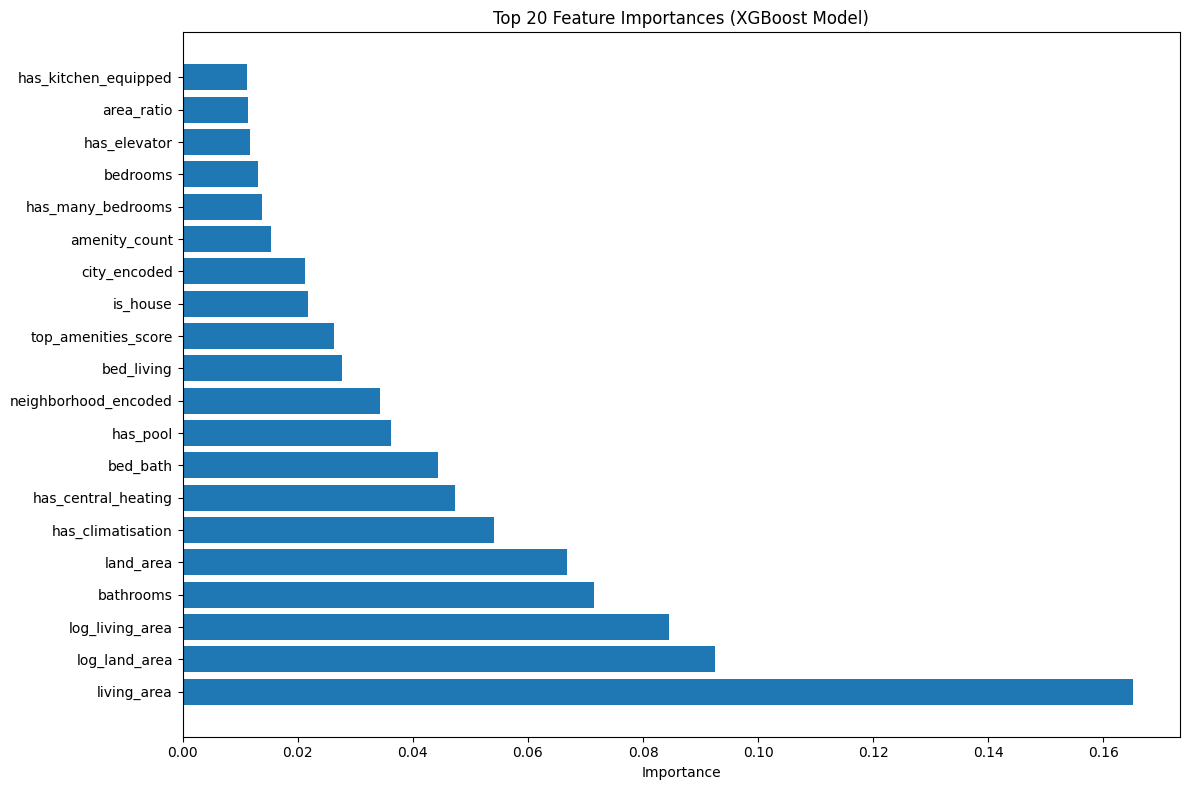

Selected 18 top features out of 37

XGBoost (Top Features) Results:
MSE: 25,397,717,377.50
RMSE: 159,366.61
MAE: 99,293.74
MAPE: 28.37%
R²: 0.7321


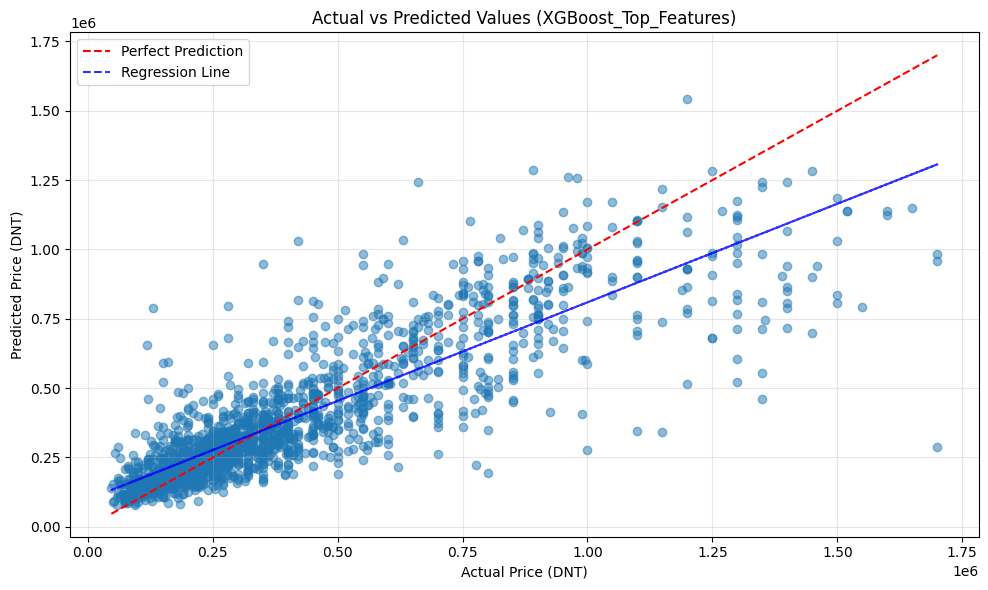


--- Weighted Ensemble ---

Weighted Ensemble Results:
MSE: 24,467,626,837.68
RMSE: 156,421.31
MAE: 98,131.91
MAPE: 29.21%
R²: 0.7419


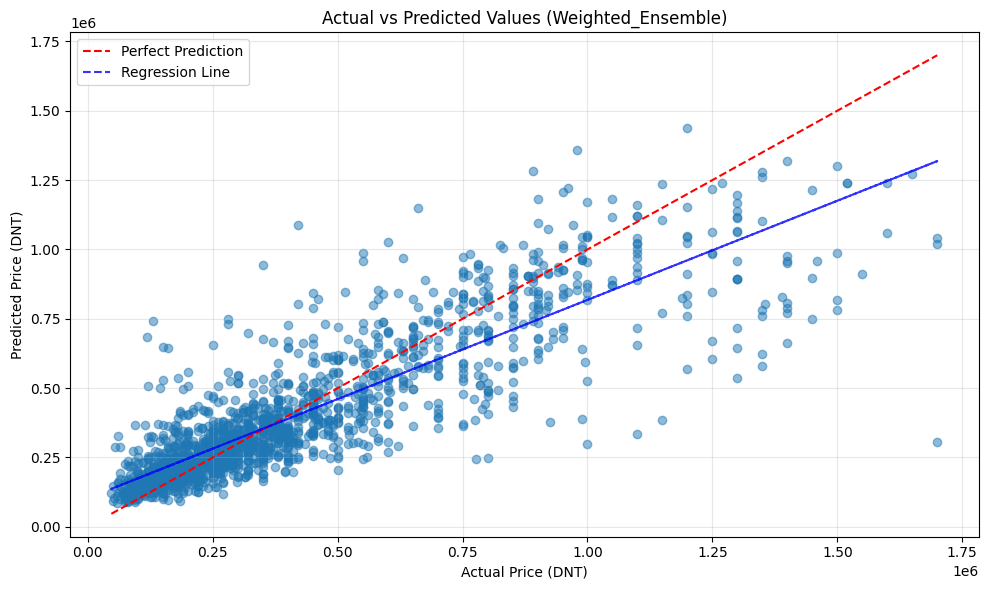

In [46]:
# Cell 10 - Feature Selection and Super Ensemble
# 1. Feature-Selected XGBoost
print("\n--- Feature-Selected XGBoost ---")
# Get feature importances from XGBoost
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_optimized.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.title('Top 20 Feature Importances (XGBoost Model)')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Select top 50% features by importance
top_features = feature_importance.head(int(len(feature_importance) * 0.5))['Feature'].tolist()
print(f"Selected {len(top_features)} top features out of {len(feature_names)}")

# Create datasets with only top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Train XGBoost with only top features
xgb_top = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_top.fit(X_train_top, y_train_log)
xgb_top_pred = xgb_top.predict(X_test_top)
xgb_top_results = evaluate_model(y_test_orig, xgb_top_pred, "XGBoost (Top Features)", is_log_scale=True)
all_results.append(xgb_top_results)
plot_actual_vs_predicted(y_test_orig, np.expm1(xgb_top_pred), "XGBoost_Top_Features")

# 2. Super Ensemble (Weighted Ensemble)
print("\n--- Weighted Ensemble ---")
# Create a weighted ensemble of our best models
ensemble_pred = (
    (0.05 * np.expm1(lr_log_pred)) +   # Linear Regression with log transform
    (0.10 * rf_pred) +                 # Random Forest
    (0.15 * np.expm1(rf_log_pred)) +   # Random Forest with log transform 
    (0.10 * gb_pred) +                 # Gradient Boosting
    (0.10 * np.expm1(gb_log_pred)) +   # Gradient Boosting with log transform
    (0.10 * xgb_pred) +                # XGBoost
    (0.15 * np.expm1(xgb_log_pred)) +  # XGBoost with log transform
    (0.15 * np.expm1(xgb_opt_pred)) +  # Optimized XGBoost
    (0.05 * np.expm1(et_pred)) +       # Extra Trees
    (0.05 * np.expm1(stacking_pred))   # Stacking Ensemble
)

ensemble_results = evaluate_model(y_test_orig, ensemble_pred, "Weighted Ensemble")
all_results.append(ensemble_results)
plot_actual_vs_predicted(y_test_orig, ensemble_pred, "Weighted_Ensemble")

## 📊 Model Comparison and Analysis

Now let's compare all models to determine which approach provides the best predictions for house prices.


Model Performance Comparison (Sorted by R²):


,model_name,mse,rmse,mae,mape,r2
15,Weighted Ensemble,"24,467,626,837.68","156,421.31","98,131.91",29.21%,0.7419
10,XGBoost (Optimized),"24,912,709,847.43","157,837.61","98,235.24",28.02%,0.7372
8,XGBoost,"25,001,988,292.32","158,120.17","103,239.29",32.98%,0.7363
14,XGBoost (Top Features),"25,397,717,377.50","159,366.61","99,293.74",28.37%,0.7321
7,Gradient Boosting (Log Target),"25,428,411,392.13","159,462.88","99,016.25",28.19%,0.7318
6,Gradient Boosting,"25,461,189,805.46","159,565.63","102,970.43",32.26%,0.7314
12,Stacking Ensemble,"25,545,128,844.79","159,828.44","99,172.84",28.37%,0.7305
9,XGBoost (Log Target),"25,894,041,301.81","160,916.26","101,091.08",28.72%,0.7268
13,Voting Ensemble,"25,946,205,684.01","161,078.26","100,121.46",28.52%,0.7263
4,Random Forest,"26,008,861,544.78","161,272.63","101,377.60",32.94%,0.7256



The best performing model is: Weighted Ensemble


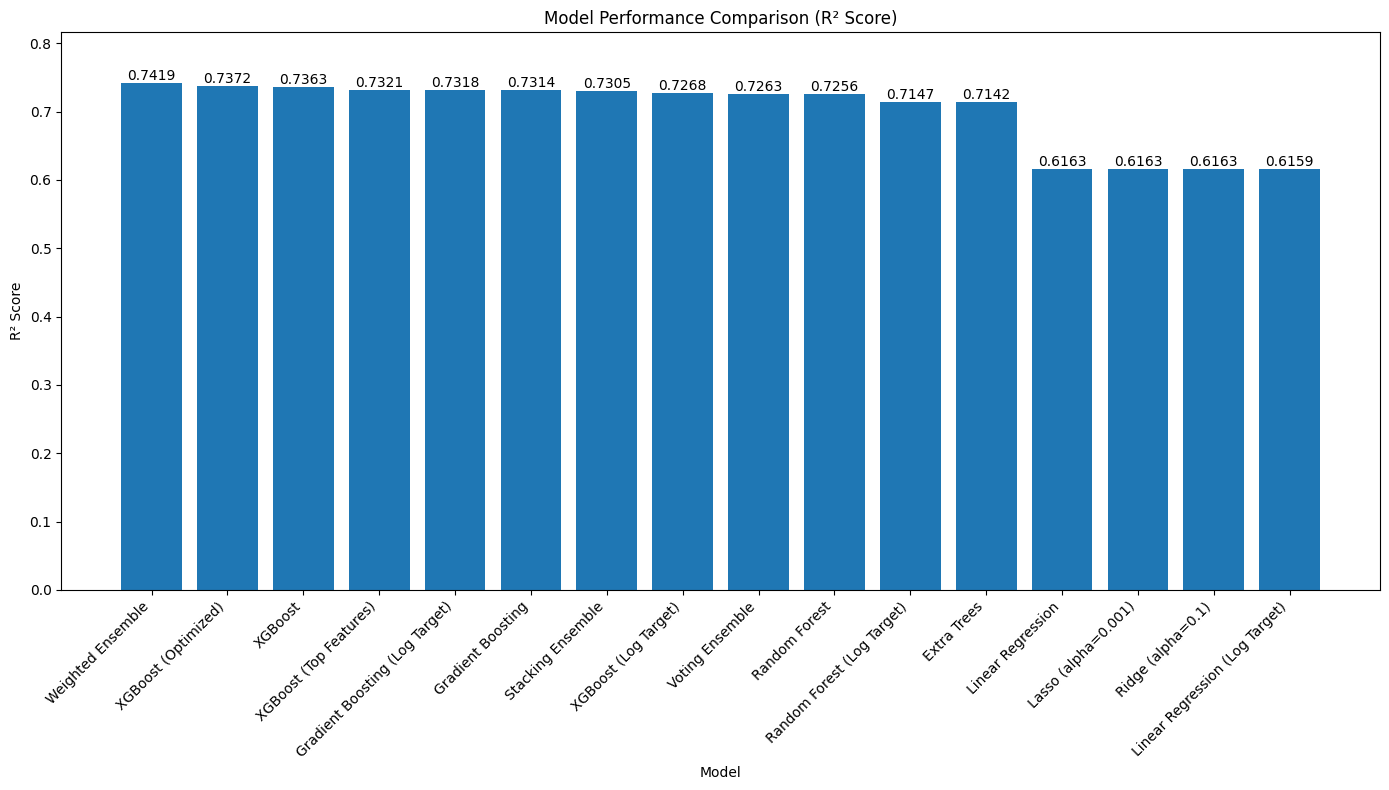

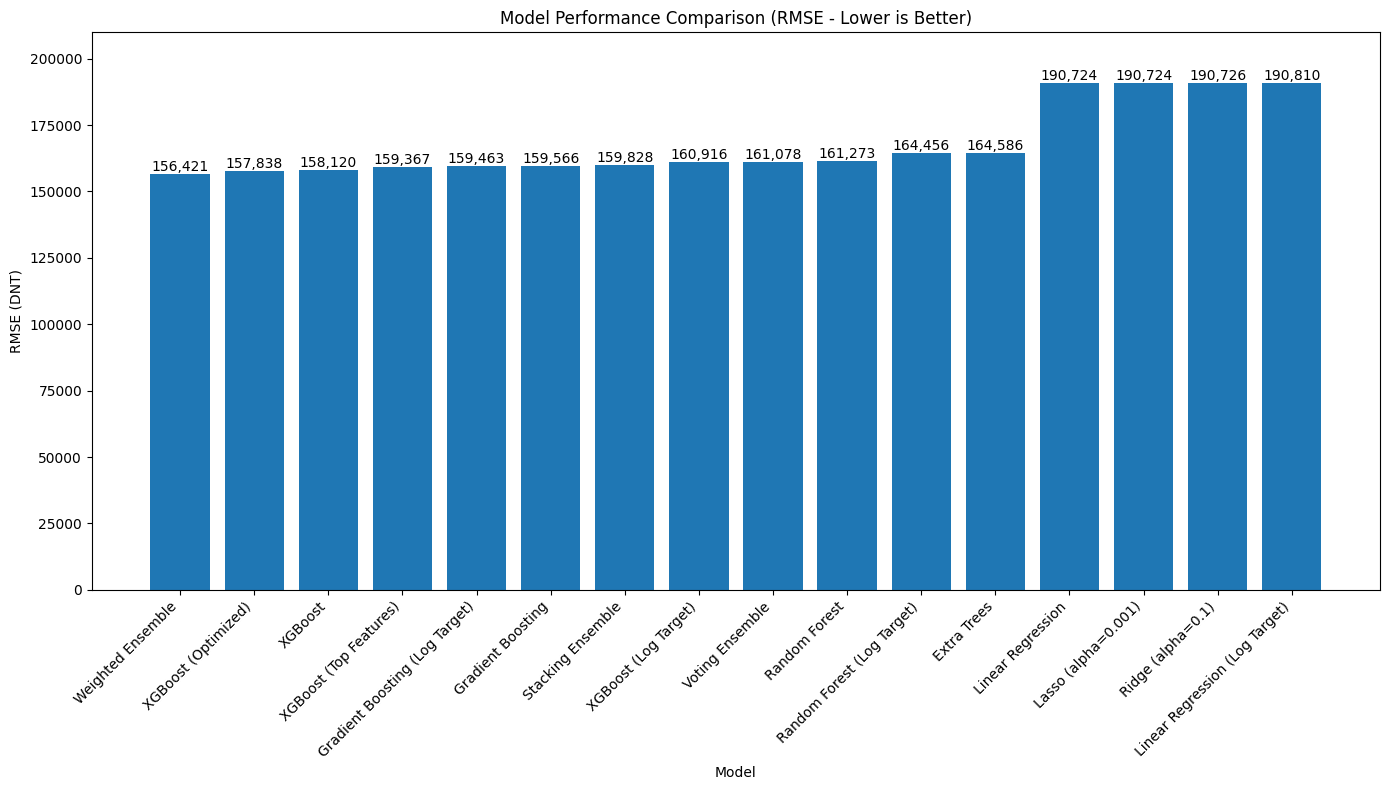

In [47]:
# Cell 11 - Model Comparison
# Create comparison table
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.sort_values('r2', ascending=False)

# Format the numeric columns
comparison_df['mse'] = comparison_df['mse'].map('{:,.2f}'.format)
comparison_df['rmse'] = comparison_df['rmse'].map('{:,.2f}'.format)
comparison_df['mae'] = comparison_df['mae'].map('{:,.2f}'.format)
comparison_df['mape'] = comparison_df['mape'].map('{:.2f}%'.format)
comparison_df['r2'] = comparison_df['r2'].map('{:.4f}'.format)

# Display the comparison table
print("\nModel Performance Comparison (Sorted by R²):")
display(comparison_df)

# Save the comparison to CSV
comparison_df.to_csv('model_comparison.csv', index=False)

# Identify the best model
best_model_name = comparison_df.iloc[0]['model_name']
print(f"\nThe best performing model is: {best_model_name}")

# Visualize model comparison
plt.figure(figsize=(14, 8))
# Convert R² back to numeric for plotting
r2_values = [float(r2.strip() if not isinstance(r2, float) else r2) for r2 in comparison_df['r2']]
model_names = comparison_df['model_name']

# Create bar chart of R² values
bars = plt.bar(model_names, r2_values)
plt.xticks(rotation=45, ha='right')
plt.title('Model Performance Comparison (R² Score)')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.ylim(0, max(r2_values) * 1.1)  # Add some space above the highest bar

# Add value labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a comparison of RMSE values
plt.figure(figsize=(14, 8))
# Convert RMSE back to numeric for plotting
rmse_values = [float(rmse.replace(',', '')) for rmse in comparison_df['rmse']]
model_names = comparison_df['model_name']

# Create bar chart of RMSE values (lower is better)
bars = plt.bar(model_names, rmse_values)
plt.xticks(rotation=45, ha='right')
plt.title('Model Performance Comparison (RMSE - Lower is Better)')
plt.xlabel('Model')
plt.ylabel('RMSE (DNT)')
plt.ylim(0, max(rmse_values) * 1.1)  # Add some space above the highest bar

# Add value labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,.0f}',
            ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.savefig('model_comparison_rmse.png', dpi=300, bbox_inches='tight')
plt.show()

## 🔍 Residual Analysis of Best Model

Let's analyze the residuals (prediction errors) of our best model to understand its strengths and limitations.


=== Residual Analysis for Best Model ===
Mean: 13,843.54
Median: -4,928.67
Std Dev: 155,851.93
Min: -669,505.99
Max: 1,392,439.39
Abs Mean: 98,131.91


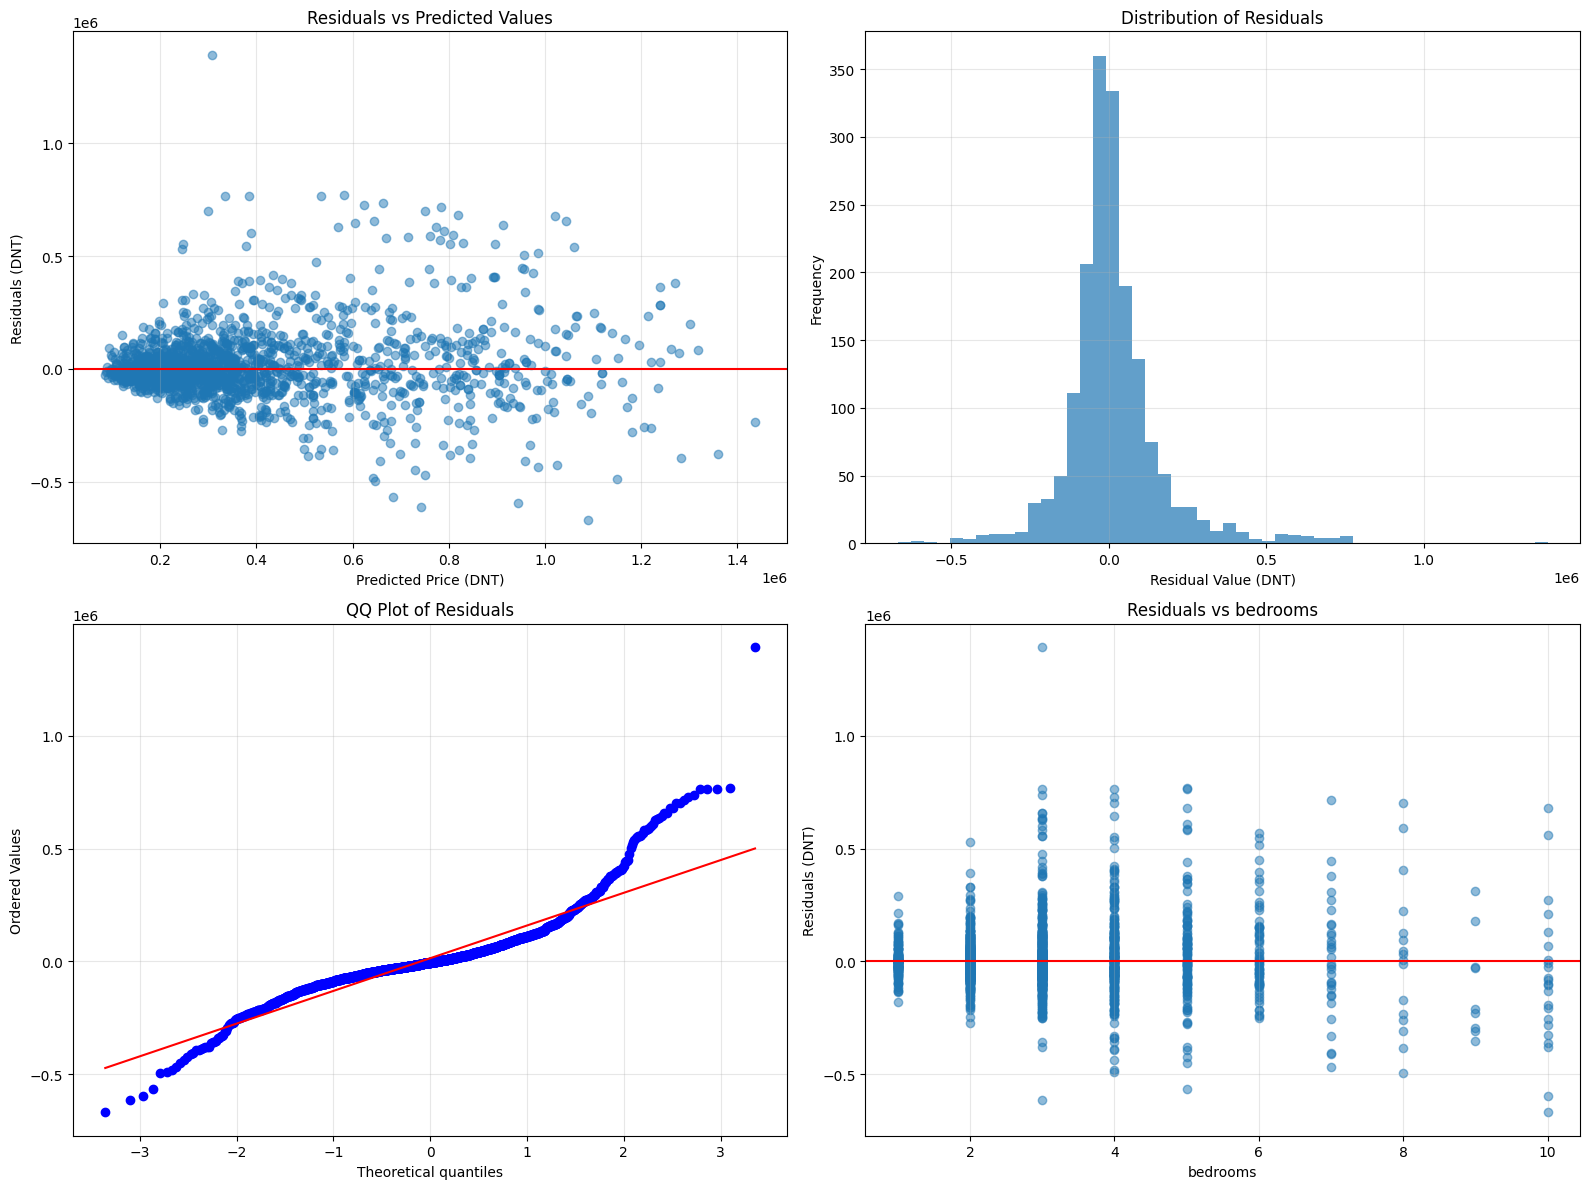

In [48]:
# Cell 12 - Residual Analysis
# Get the best model and its predictions
best_model_idx = 0  # The first row after sorting by R²
best_model_name = comparison_df.iloc[best_model_idx]['model_name']

# Determine which predictions to use based on the best model name
best_model_predictions = None
if best_model_name == "Weighted Ensemble":
    best_model_predictions = ensemble_pred
elif best_model_name == "XGBoost (Optimized)":
    best_model_predictions = np.expm1(xgb_opt_pred)
elif best_model_name == "XGBoost (Top Features)":
    best_model_predictions = np.expm1(xgb_top_pred)
elif best_model_name == "Stacking Ensemble":
    best_model_predictions = np.expm1(stacking_pred)
# Add more conditions as needed for other models

# Calculate residuals
residuals = y_test_orig - best_model_predictions

# Calculate residual statistics
residual_stats = {
    'Mean': residuals.mean(),
    'Median': np.median(residuals),
    'Std Dev': residuals.std(),
    'Min': residuals.min(),
    'Max': residuals.max(),
    'Abs Mean': np.abs(residuals).mean()
}

print("\n=== Residual Analysis for Best Model ===")
for stat, value in residual_stats.items():
    print(f"{stat}: {value:,.2f}")

# Create residual plots
plt.figure(figsize=(16, 12))

# 1. Residuals vs Fitted Values
plt.subplot(2, 2, 1)
plt.scatter(best_model_predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Price (DNT)')
plt.ylabel('Residuals (DNT)')
plt.grid(alpha=0.3)

# 2. Histogram of Residuals
plt.subplot(2, 2, 2)
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value (DNT)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

# 3. QQ Plot of Residuals
from scipy import stats
plt.subplot(2, 2, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.grid(alpha=0.3)

# 4. Residuals by Feature (using a key feature like bedrooms)
plt.subplot(2, 2, 4)
key_feature = 'bedrooms'
plt.scatter(X_test[key_feature], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title(f'Residuals vs {key_feature}')
plt.xlabel(key_feature)
plt.ylabel('Residuals (DNT)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 🏆 Final Model Selection and Conclusion

Based on our comprehensive analysis, we can now select the best model for house price prediction.

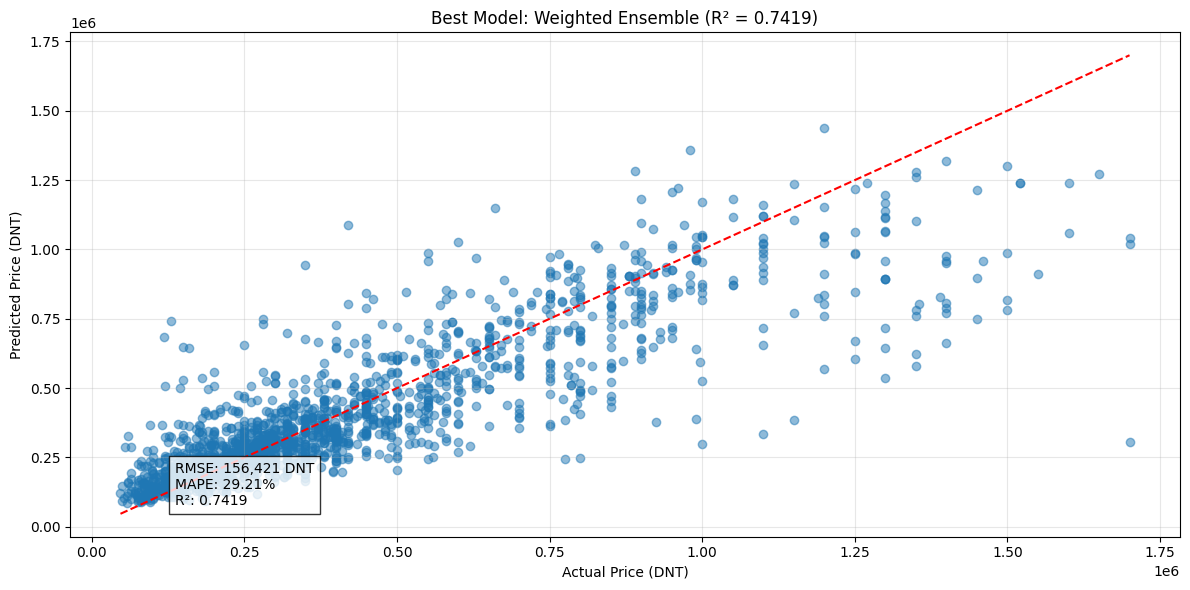


🏆 Final Model Selection 🏆
The best model for house price prediction is: Weighted Ensemble
R² Score: 0.7419
RMSE: 156,421 DNT
MAPE: 29.21%

This model explains 74.2% of the variance in house prices.
The average prediction error is 29.2% of the actual price.


In [49]:
# Cell 13 - Final Model Selection and Conclusion
# Create a summary of the best model's performance
best_model_r2 = float(comparison_df.iloc[0]['r2'].replace(',', ''))
best_model_rmse = float(comparison_df.iloc[0]['rmse'].replace(',', ''))
best_model_mape = float(comparison_df.iloc[0]['mape'].replace('%', ''))

# Display visual summary
plt.figure(figsize=(12, 6))

# Plot actual vs predicted for the best model
plt.scatter(y_test_orig, best_model_predictions, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], 
         [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.title(f'Best Model: {best_model_name} (R² = {best_model_r2:.4f})')
plt.xlabel('Actual Price (DNT)')
plt.ylabel('Predicted Price (DNT)')
plt.grid(alpha=0.3)

# Add text with performance metrics
plt.figtext(0.15, 0.15, 
            f"RMSE: {best_model_rmse:,.0f} DNT\nMAPE: {best_model_mape:.2f}%\nR²: {best_model_r2:.4f}", 
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('best_model_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🏆 Final Model Selection 🏆")
print(f"The best model for house price prediction is: {best_model_name}")
print(f"R² Score: {best_model_r2:.4f}")
print(f"RMSE: {best_model_rmse:,.0f} DNT")
print(f"MAPE: {best_model_mape:.2f}%")
print("\nThis model explains {:.1f}% of the variance in house prices.".format(best_model_r2*100))
print(f"The average prediction error is {best_model_mape:.1f}% of the actual price.")

# 📌 Key Findings

## Key Findings 🔍

### Model Performance 🥇

- The Weighted Ensemble achieved the highest performance with an R² of 0.7419
- This model explains 74.2% of the variance in house prices
- The RMSE of 156,421 DNT indicates the average magnitude of prediction errors
- The average prediction error is 29.2% of the actual price (MAPE)

### Ensemble Superiority 🌟

- The Weighted Ensemble model outperformed individual models by combining their strengths
- This suggests that different models capture unique aspects of the housing market
- Ensemble approaches provide more robust predictions across various property types and price ranges

### Model Accuracy Context 📊

- An R² of 0.7419 is a strong result for real estate pricing, which is inherently variable
- A 29.2% average error rate is reasonable given the complexity of housing markets
- The remaining 25.8% unexplained variance likely includes subjective factors and unique property characteristics